<a href="https://colab.research.google.com/github/edwin-19/NLP_ZShot/blob/main/SetFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lets install our libraries
- We need to install setfit
- As weel as hf dataset

In [1]:
!pip install setfit
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.6 MB/s 
     |████████████████████████████████| 85 kB 2.3 MB/s 
     |████████████████████████████████| 362 kB 45.0 MB/s 
     |████████████████████████████████| 95 kB 2.6 MB/s 
     |████████████████████████████████| 182 kB 43.0 MB/s 
     |████████████████████████████████| 212 kB 48.0 MB/s 
     |████████████████████████████████| 132 kB 52.0 MB/s 
     |████████████████████████████████| 5.8 MB 33.6 MB/s 
     |████████████████████████████████| 1.3 MB 28.7 MB/s 
     |████████████████████████████████| 127 kB 54.1 MB/s 
     |████████████████████████████████| 7.6 MB 45.0 MB/s 
     |████████████████████████████████| 131 kB 60.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=0c7dc623900b778ad59100b4c5a6eeee26eeff32a1b758c0ad5ac5826fb7d911
  Stored in directory: /root/.

# Lets import our libraries here

In [10]:
from datasets import load_dataset

from matplotlib import pyplot as plt
import seaborn as sns

# Lets import our dataset here
- Then lets explore a bit

In [3]:
# Load a dataset from the Hugging Face Hub
dataset = load_dataset("sst2")

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset sst2 downloaded and prepared to /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

In [13]:
# Convert to df
df = dataset['train'].to_pandas()
df['count'] = df['sentence'].apply(lambda x: len(x.split(' ')))
df.head()

,idx,sentence,label,count
0,0,hide new secretions from the parental units,0,8
1,1,"contains no wit , only labored gags",0,8
2,2,that loves its characters and communicates som...,1,13
3,3,remains utterly satisfied to remain the same t...,0,9
4,4,on the worst revenge-of-the-nerds clichés the ...,0,11


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


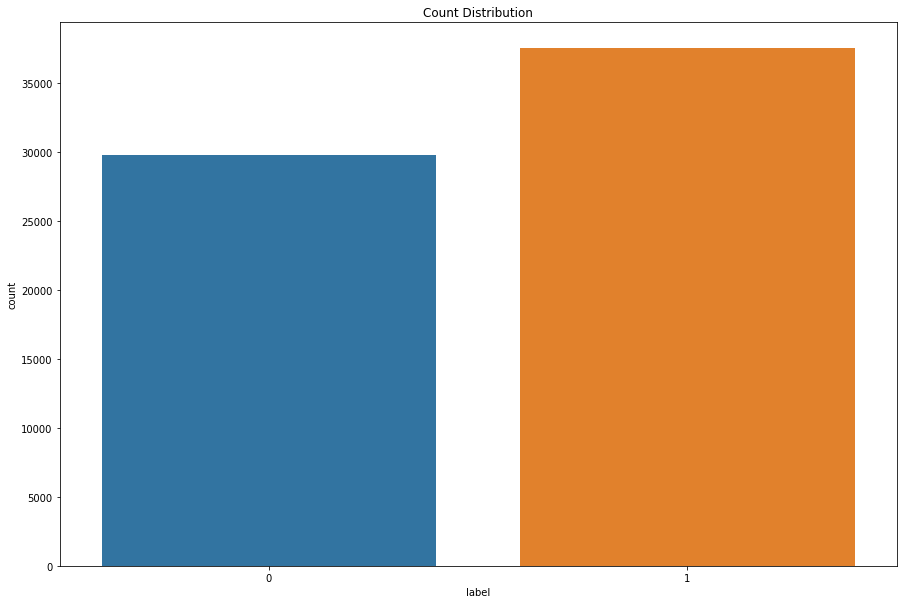

In [12]:
plt.figure(figsize=(15, 10))
plt.title('Count Distribution')
sns.countplot(df['label'])

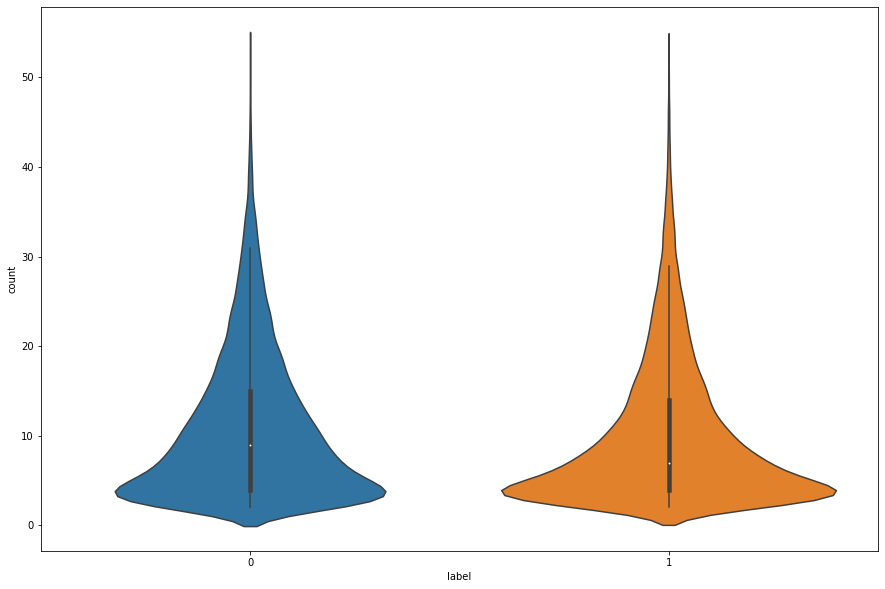

In [15]:
plt.figure(figsize=(15, 10))
sns.violinplot(data=df, y='count', x='label')

# Lets create a setfit model and trainer and train our model on only 8 samples

In [16]:
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer, sample_dataset

In [17]:
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

Downloading:   0%|          | 0.00/594 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.70k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/594 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [18]:
# Simulate the few-shot regime by sampling 8 examples per class
train_dataset = sample_dataset(dataset["train"], label_column="label", num_samples=8)
eval_dataset = dataset["validation"]

  0%|          | 0/68 [00:00<?, ?ba/s]

  0%|          | 0/68 [00:00<?, ?ba/s]

In [20]:
# Create trainer
trainer = SetFitTrainer(
    model=model, train_dataset=train_dataset, eval_dataset=eval_dataset,
    loss_class=CosineSimilarityLoss, metric='accuracy', 
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for constrastive learning
    column_mapping={"sentence": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
)

In [21]:
# Train and evaluate
trainer.train()
metrics = trainer.evaluate()

Applying column mapping to training dataset
***** Running training *****
  Num examples = 640
  Num epochs = 1
  Total optimization steps = 40
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****


In [22]:
metrics

{'accuracy': 0.8428899082568807}

In [23]:
model(['I love spiderman', 'man this is dumb'])

array([1, 0])

# Evaluate model

In [41]:
from sklearn.metrics import classification_report, confusion_matrix

In [39]:
input_data = [data['sentence'] for data in dataset['validation']]
gt_data = [data['label'] for data in dataset['validation']]
results = model(input_data)

In [40]:
print(classification_report(gt_data, results))

              precision    recall  f1-score   support

           0       0.78      0.95      0.86       428
           1       0.94      0.74      0.83       444

    accuracy                           0.84       872
   macro avg       0.86      0.84      0.84       872
weighted avg       0.86      0.84      0.84       872



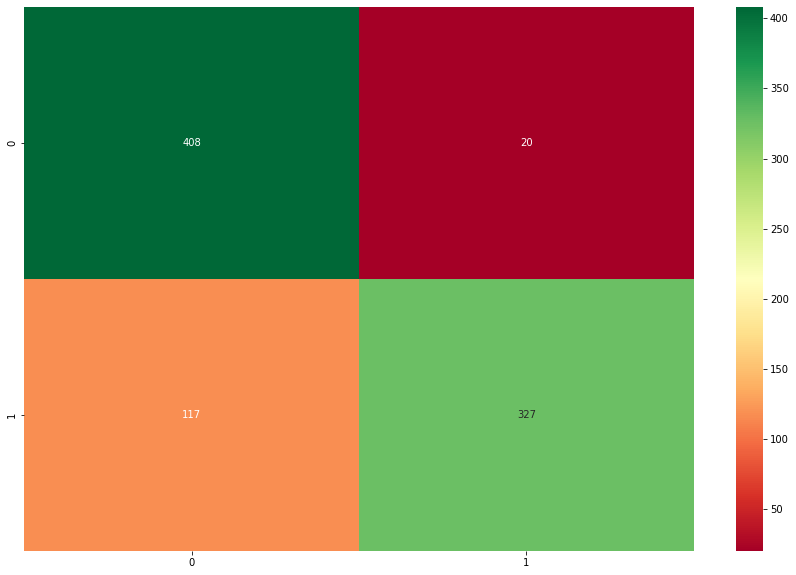

In [46]:
cm = confusion_matrix(gt_data, results)

plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot = True, fmt="1", cmap='RdYlGn')